# Testing platform-independent quantum error mitigation on noisy quantum computers

In this notebook, we a cover a subset of the techniques and results obtained in [arXiv:2210.07194](https://arxiv.org/abs/2210.07194).

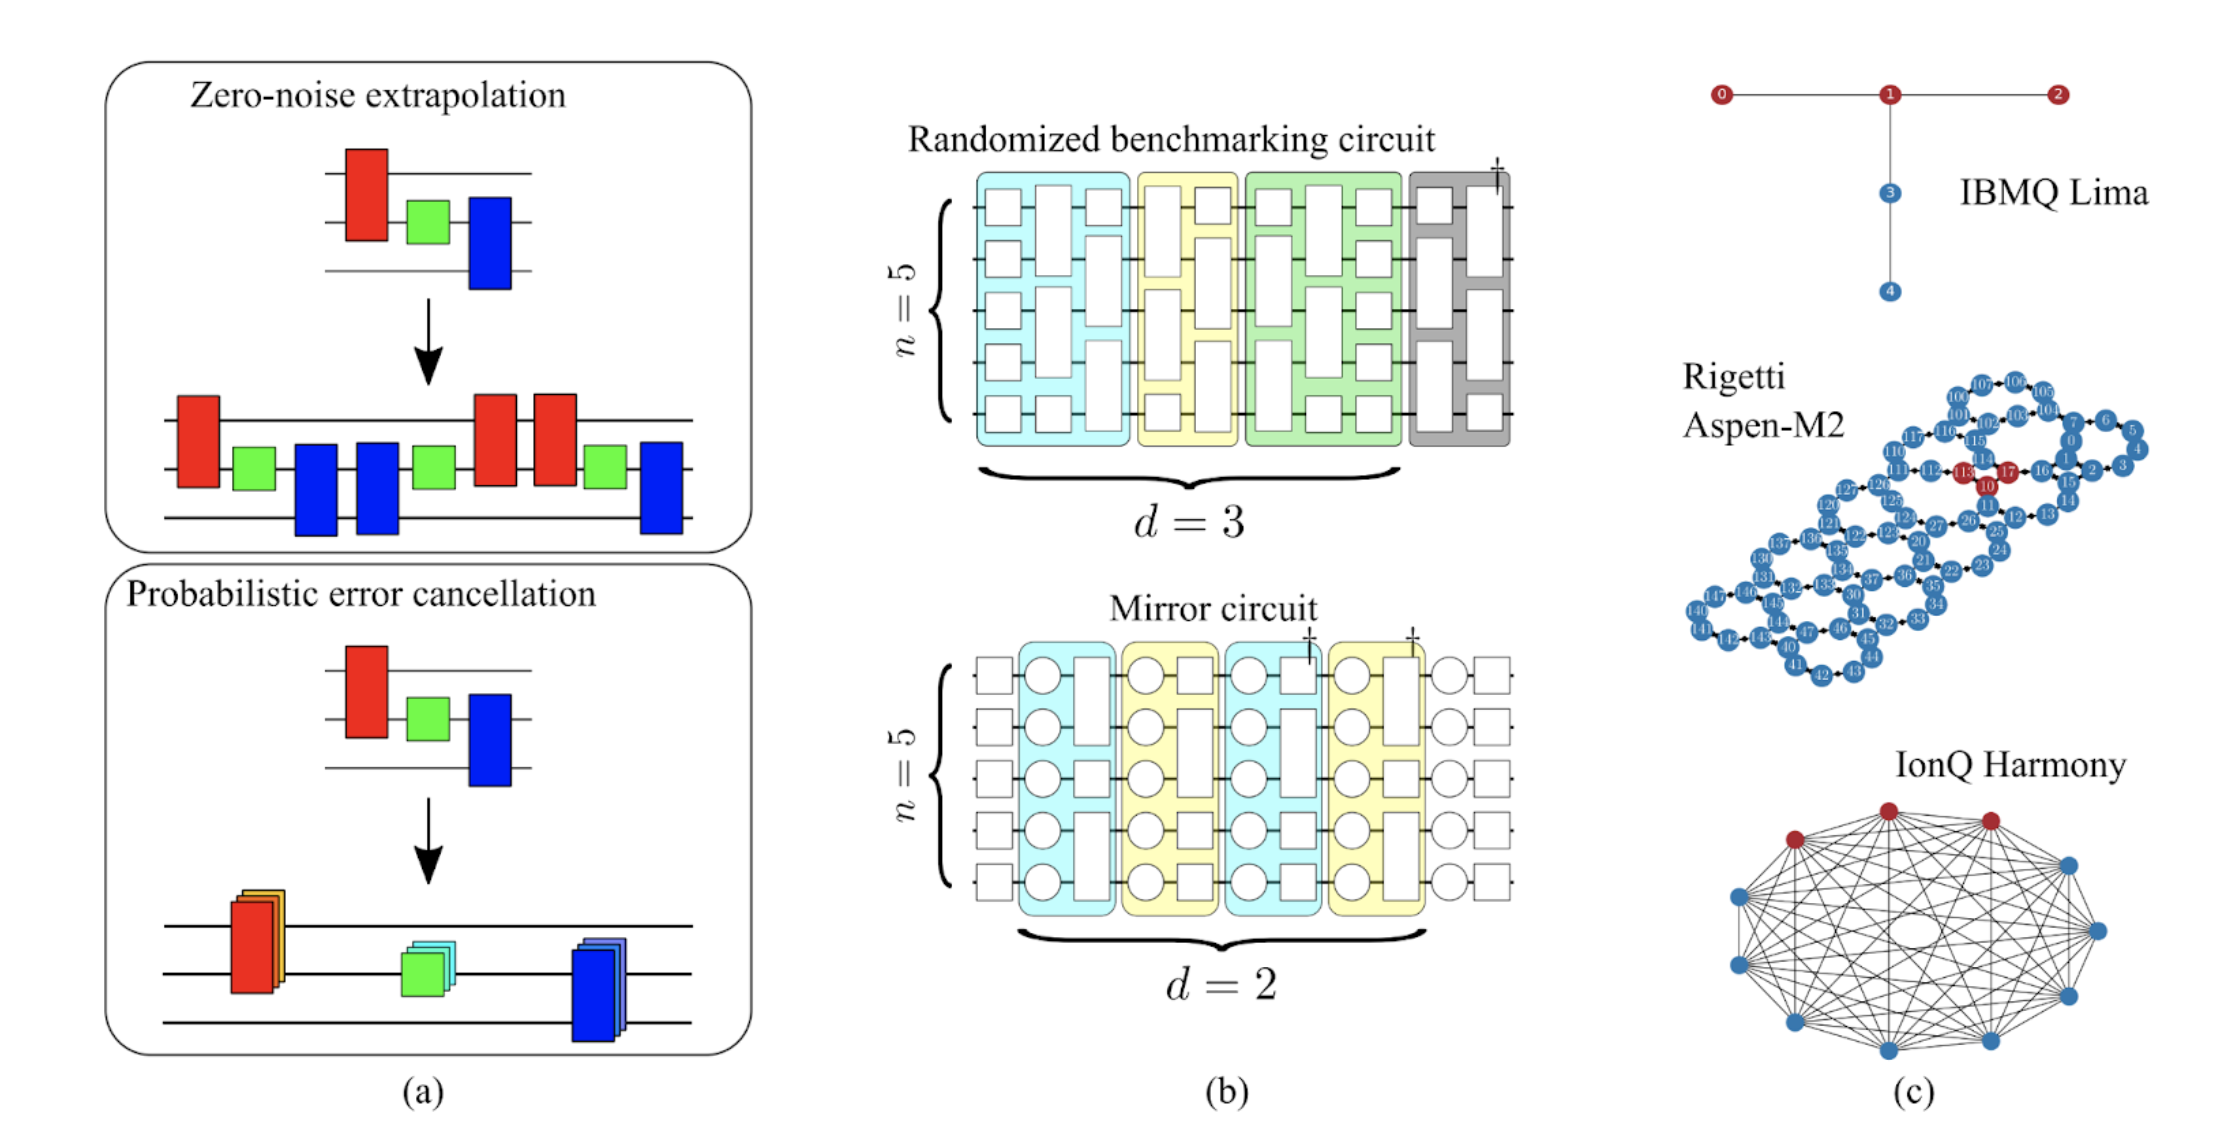

## Reference links

* Benchmarking paper (arXiv:2210.07194): https://arxiv.org/abs/2210.07194
* Benchmarking paper (software): https://github.com/unitaryfund/research/tree/main/qem-on-hardware
* Mitiq repository: https://github.com/unitaryfund/mitiq
* Mitiq documentation: https://mitiq.readthedocs.io/en/latest/index.html
* Mitiq docs on ZNE: https://mitiq.readthedocs.io/en/latest/guide/zne.html
* Mitiq white paper (arXiv:2009.04417): https://arxiv.org/abs/2009.04417
* UnitaryFund: https://unitary.fund/

## Dependencies:

* Python 3.10+
* `mitiq==0.26.0`
* `qiskit==0.43.1`
* `qiskit-ignis==0.7.1`

## Zero-noise extrapolation (ZNE)

Zero-noise extrapolation (ZNE) is an error mitigation technique in which an expectation value is computed at different noise levels and, as a second step, the ideal expectation value is inferred by extrapolating the measured results to the zero-noise limit.

### ZNE in theory

The primary idea of ZNE can be captured in the following image:

* 
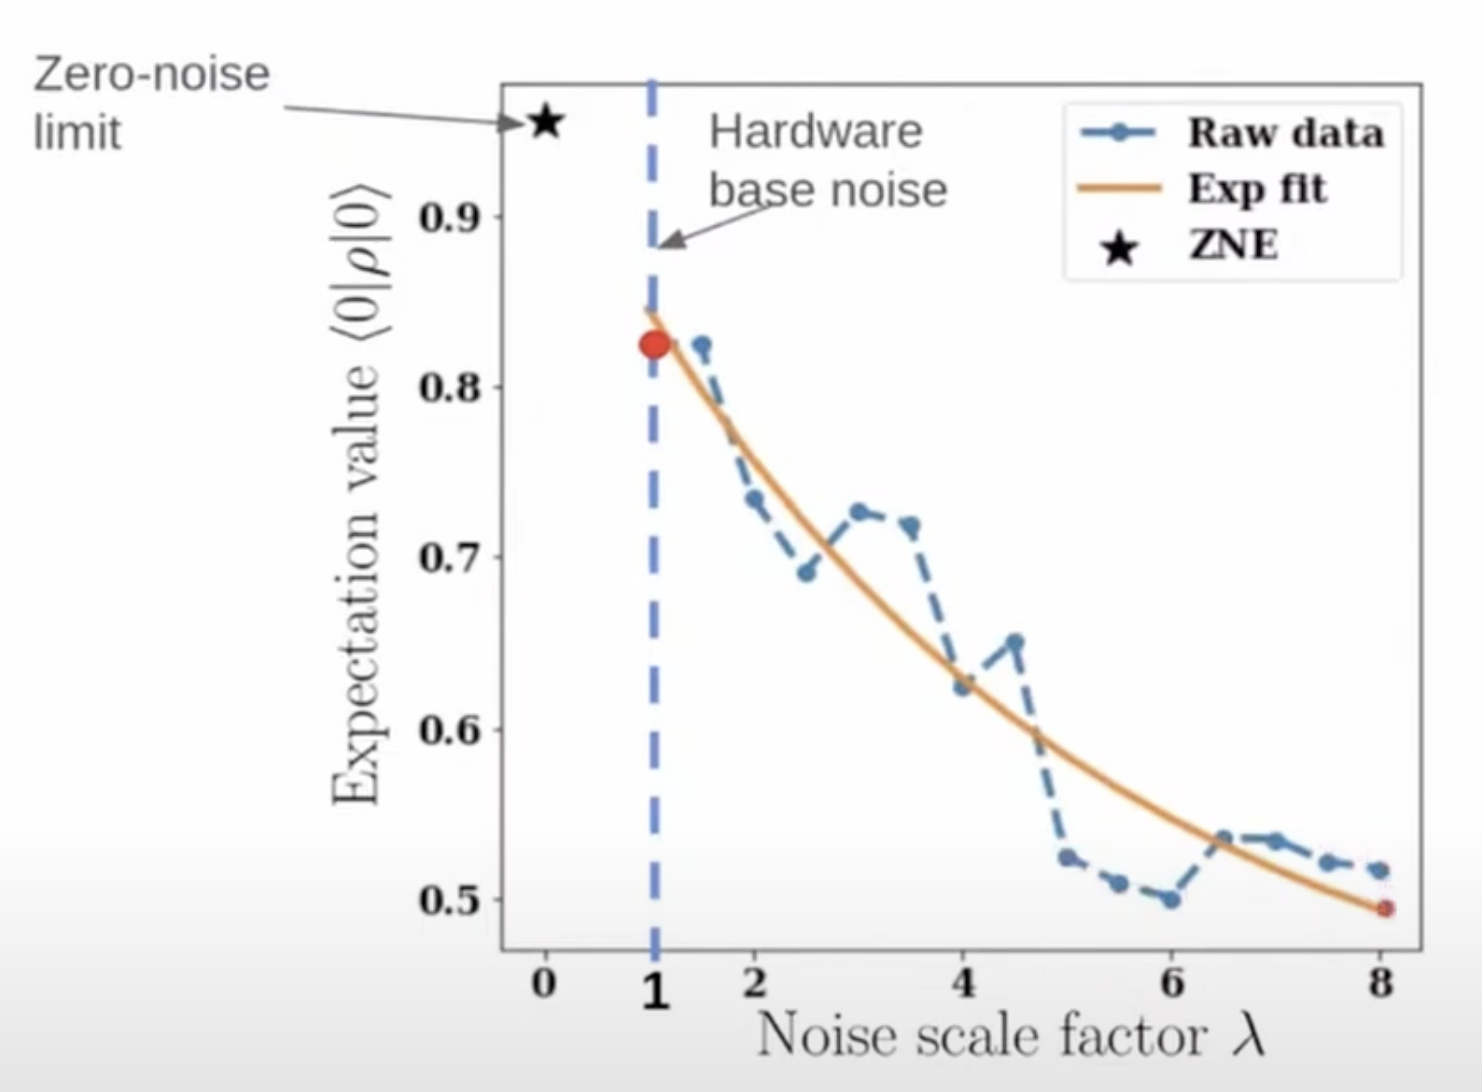

**Scenario**: We have a quantum circuit that we wish to run and are computing some expectation value.

**Problem**: There is some base hardware noise (represented by the vertical blue dotted line) that we cannot exceed.

**Want**: Get to zero-noise limit but the noise blocks us from getting there.

**Solution**: 
   - Can't "move left", but we can "move right" by intentionally increasing the noise of our circuit.
   - Can then compute expectation values (blue points on dotted curve) for each noise scale factor.
   - Then, we can fit a curve to these expectation values and deduce what the zero-noise limit is.

ZNE has two main steps:

1. **Intentionally scale noise.** This can be done with different methods. Pulse-stretching can be used to increase the noise level of a quantum computation. Similar results can be obtained, at a gate-level, with unitary folding or identity insertion scaling.

2. **Extrapolate to the noiseless limit.** This can be done by fitting a curve (often called extrapolation model) to the expectation values measured at different noise levels to extrapolate the noiseless expectation value.

### ZNE in practice with Mitiq

[Mitiq](https://mitiq.readthedocs.io/en/latest/index.html) is a Python toolkit for implementing error mitigation techniques on quantum computers.

Current quantum computers are noisy due to interactions with the environment, imperfect gate applications, state preparation and measurement errors, etc. Error mitigation seeks to reduce these effects at the software level by compiling quantum programs in clever ways.

* 

### Applying ZNE with Mitiq

There are three steps to ZNE in Mitiq:

1. Define circuit to run.

2. Define a function that executes the circuit and returns the observable of interest.

3. Use `zne.execute_with_zne` with these ingredients. Optionally, pick a noise-scaling method and/or inference technique.

## Setup

In [1]:
import os
import functools
import time
from typing import List, Tuple, Union

# Plotting imports.
import matplotlib.pyplot as plt
plt.rcParams.update({"font.family": "serif", "font.size": 15})
%matplotlib inline

# Third-party imports.
import cirq
import numpy as np

# Qiskit imports.
import qiskit
import qiskit.ignis.verification.randomized_benchmarking as rb
from qiskit.transpiler.passes import RemoveBarriers, RemoveFinalMeasurements

# Mitiq imports.
from mitiq.interface import convert_to_mitiq, convert_from_mitiq
from mitiq import benchmarks, zne

/var/folders/vw/cdx3n5yj7xl3q3g2fv2m676m0000gp/T/ipykernel_24637/59130168.py:17: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  import qiskit.ignis.verification.randomized_benchmarking as rb


## Parameters

In [2]:
# Option to use a noisy simulator instead of hardware backend.
use_noisy_simulator: bool = True  

# Minimum depth circuit to use.
min_depth: int = 1          
# Random seed for circuit generation.
seed: int = 1               

# Minimum noise scale factor.
min_scale_factor: int = 1   
# Maximum noise scale factor.
max_scale_factor: int = 3   

# Step between noise scale factors.
step_scale_factor: int = 1  

# Total number of shots to use.
# For ZNE, the shots per circuit is shots / len(scale_factors).
shots: int = 10_000     

## Circuit parameters

In [3]:
# Qubits to use on the experiment. 
num_qubits = 3
qubits = [j for j in range(num_qubits)]

# Split qubits into 2-qubit pairs (assuming a chain connectivity). 
rb_pattern = [[qa, qb] for qa, qb in zip(qubits[0:-1:2], qubits[1::2])]
if len(qubits) % 2 == 1:
    # For an odd number of qubits, append final individual qubit to the RB pattern.
    rb_pattern.append([qubits[-1]])
print("Qubit indeces:", qubits)
print("RB pattern:", rb_pattern)
        
# Maximum depth circuit to use.    
max_depth: int = 20

# Step to create a list of depths to run at.
step_depth: int = 2
        
# Average results over this many trials (circuit instances) at each depth.
trials: int = 4     

Qubit indeces: [0, 1, 2]
RB pattern: [[0, 1], [2]]


## IBM qubit settings

In [4]:
# Physical qubits with a chain-like connectivity.
ibm_lima_ordering = [0, 1, 3, 4, 2]

# Assume ibmq-lima device. Take n adjacent physical qubits.
physical_ibm_qubits = ibm_lima_ordering[:len(qubits)] 

print("IBM physical qubits:", physical_ibm_qubits)

IBM physical qubits: [0, 1, 3]


## Error mitigation options

In [5]:
# Noise scaling method.
fold_method = zne.scaling.fold_global

depths = list(range(min_depth, max_depth + 1, step_depth))

scale_factors = tuple(range(min_scale_factor, max_scale_factor + 1, step_scale_factor))

print(f"Depths: {depths}")
print(f"Scale factors: {scale_factors}")

Depths: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
Scale factors: (1, 2, 3)


## Hardware architecture

If the user selects the option to run on an actual hardware offering, define the architectural layout of the quantum device. Otherwise, invoke the appropriate simulator.

In [6]:
from qiskit.providers.fake_provider import FakeLima

noisy_backend = FakeLima()
ideal_backend = qiskit.Aer.get_backend("aer_simulator")
    
print(f"Noisy backend: {noisy_backend}")
print(f"Ideal backend: {ideal_backend}")

Noisy backend: fake_lima
Ideal backend: aer_simulator


## Benchmark circuit

In [7]:
def named_qubit_to_line_qubit(named_qubit: str) -> cirq.LineQubit:
    """Extract qubit number assuming "_" is used as a word separator."""
    digits = [int(s) for s in named_qubit.name.split("_") if s.isdigit()]
    if len(digits) == 1:
        return cirq.LineQubit(digits[0])
    else:
        raise RuntimeError("Failed to identify qubit number.")

In [8]:
def get_circuit(depth: int, seed: int) -> Union[Tuple[cirq.Circuit, str], Tuple[qiskit.QuantumCircuit, str]]:
    circuit = rb.randomized_benchmarking_seq(
        length_vector=[depth], 
        rb_pattern=rb_pattern,
        group_gates="0", 
        rand_seed=seed,
    )[0][0][0]

    # Remove barriers and measurements.
    circuit = RemoveFinalMeasurements()(RemoveBarriers()(circuit))

    # Hack: Remove classical register and rename qubit register.
    return convert_from_mitiq(convert_to_mitiq(circuit)[0], "qiskit"), "0" * len(qubits)

## CNOT count utility functions

In [9]:
def get_num_cnot_count(circuit: Union[cirq.Circuit, qiskit.QuantumCircuit]) -> int:
    """Determine number of cnot gates in a given `Circuit` object."""    
    return circuit.count_ops().get("cx")

def get_avg_cnot_count(circuits: Union[List[cirq.Circuit], List[qiskit.QuantumCircuit]]) -> float:
    """Determine average number of cnot gates present in 
    list of either `Circuit` or `QuantumCircuit` objects."""    
    return np.average([c.count_ops().get("cx") for c in circuits])
    
def get_oneq_count(circuit: Union[cirq.Circuit, qiskit.QuantumCircuit]) -> int:
    return len(circuit) - get_num_cnot_count(circuit)

## Executor

In [10]:
def execute(
    circuits: Union[cirq.Circuit, List[cirq.Circuit]], 
    backend,
    shots: int,
    correct_bitstring: str,
    verbose: bool = True,
    is_noisy: bool = True,
) -> List[float]:
    """Executes the input circuit(s) and returns ⟨A⟩, where 
    A = |correct_bitstring⟩⟨correct_bitstring| for each circuit.
    """
    if not isinstance(circuits, list):
        circuits = [circuits]
    
    if verbose:
        # Calculate average number of CNOT gates per circuit.
        print(f"Executing {len(circuits)} circuit(s) on {backend}.")            
        print(f"Average cnot count in circuits: {get_avg_cnot_count(circuits)}")

    # Store all circuits to run in list to be returned.
    to_run = []

    # Transpile circuits for IBMQ.
    for circuit in circuits:
        circuit_to_run = circuit.copy()

        circuit_to_run.measure_all()
        to_run.append(
            qiskit.transpile(
                circuit_to_run,
                backend=backend,
                initial_layout=physical_ibm_qubits,
                optimization_level=0, # Otherwise RB circuits are simplified to empty circuits.
            )
        )

    if verbose:
        # Calculate average number of CNOT gates per compiled circuit.
        print(f"Average cnot count in compiled circuits: {get_avg_cnot_count(to_run)}")
           
    # Run and get counts.
    job = backend.run(
        to_run,
        # Reset qubits to ground state after each sample.
        init_qubits=True,  
        shots=shots,
    )
    # IBMQ uses online queue for processing jobs.
    if verbose and not use_noisy_simulator:
        time.sleep(3)
        while not job.in_final_state():
            print(f"Queue position: {job.queue_position()}")
            time.sleep(verbose_update_time)
        print()

    if len(circuits) == 1:
        return [job.result().get_counts().get(correct_bitstring, 0.0) / shots]
    return [count.get(correct_bitstring, 0.0) / shots for count in job.result().get_counts()]

## Experiment

In [11]:
cnot_counts, oneq_counts = [], []
true_values, noisy_values = [], []
zne_values = []
noise_scaled_expectation_values = []

for depth in depths:
    print("Status: On depth", depth, end="\n\n")
    
    cnot_depth_counts, oneq_depth_counts = [], []
    true_depth_values, noisy_depth_values = [], []
    zne_depth_values = []

    noise_scaled_expectation_depth_values = []

    for trial in range(trials):
        # Local seed is calculated in this way to ensure that we don't get repeat values in loop.        
        local_seed = 10**6 * depth + 10**3 * seed + trial
        
        circuit, correct_bitstring = get_circuit(depth, local_seed)

        true_value, = execute(circuit, ideal_backend, shots, correct_bitstring, is_noisy=False)
        noisy_value, = execute(circuit, noisy_backend, shots, correct_bitstring, is_noisy=True)
        
        zne_executor = functools.partial(
            execute, 
            backend=noisy_backend, 
            shots=shots // len(scale_factors),
            correct_bitstring=correct_bitstring,
        )                        
        richardson_factory = zne.inference.RichardsonFactory(scale_factors=scale_factors)            
        zne_value = zne.execute_with_zne(circuit, 
                                         zne_executor, 
                                         scale_noise=fold_method, 
                                         factory=richardson_factory)
        zne_depth_values.append(zne_value)       
        noise_scaled_expectation_depth_values.extend(richardson_factory.get_expectation_values())
        
        cnot_depth_counts.append(get_num_cnot_count(circuit))
        oneq_depth_counts.append(get_oneq_count(circuit))
        
        true_depth_values.append(true_value)
        noisy_depth_values.append(noisy_value)
    
    cnot_counts.append(cnot_depth_counts)
    oneq_counts.append(oneq_depth_counts)
    
    true_values.append(true_depth_values)
    noisy_values.append(noisy_depth_values)
    
    noise_scaled_expectation_values.append(noise_scaled_expectation_depth_values)    
    
    zne_values.append(zne_depth_values)

Status: On depth 1

Executing 1 circuit(s) on aer_simulator.
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Executing 1 circuit(s) on fake_lima.
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Executing 3 circuit(s) on fake_lima.
Average cnot count in circuits: 8.0
Average cnot count in compiled circuits: 8.0
Executing 1 circuit(s) on aer_simulator.
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Executing 1 circuit(s) on fake_lima.
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Executing 3 circuit(s) on fake_lima.
Average cnot count in circuits: 8.0
Average cnot count in compiled circuits: 8.0
Executing 1 circuit(s) on aer_simulator.
Average cnot count in circuits: 6.0
Average cnot count in compiled circuits: 6.0
Executing 1 circuit(s) on fake_lima.
Average cnot count in circuits: 6.0
Average cnot count in compiled circuits: 6.0
Executing 3 circuit(s) o

Executing 3 circuit(s) on fake_lima.
Average cnot count in circuits: 39.666666666666664
Average cnot count in compiled circuits: 39.666666666666664
Executing 1 circuit(s) on aer_simulator.
Average cnot count in circuits: 19.0
Average cnot count in compiled circuits: 19.0
Executing 1 circuit(s) on fake_lima.
Average cnot count in circuits: 19.0
Average cnot count in compiled circuits: 19.0
Executing 3 circuit(s) on fake_lima.
Average cnot count in circuits: 39.666666666666664
Average cnot count in compiled circuits: 39.666666666666664
Executing 1 circuit(s) on aer_simulator.
Average cnot count in circuits: 18.0
Average cnot count in compiled circuits: 18.0
Executing 1 circuit(s) on fake_lima.
Average cnot count in circuits: 18.0
Average cnot count in compiled circuits: 18.0
Executing 3 circuit(s) on fake_lima.
Average cnot count in circuits: 37.333333333333336
Average cnot count in compiled circuits: 37.333333333333336
Status: On depth 13

Executing 1 circuit(s) on aer_simulator.
Averag

## Plot results

In [12]:
avg_true_values = np.average(true_values, axis=1)
avg_noisy_values = np.average(noisy_values, axis=1)

std_true_values = np.std(true_values, axis=1, ddof=1)
std_noisy_values = np.std(noisy_values, axis=1, ddof=1)

avg_zne_values = np.average(zne_values, axis=1)
std_zne_values = np.std(zne_values, axis=1, ddof=1)

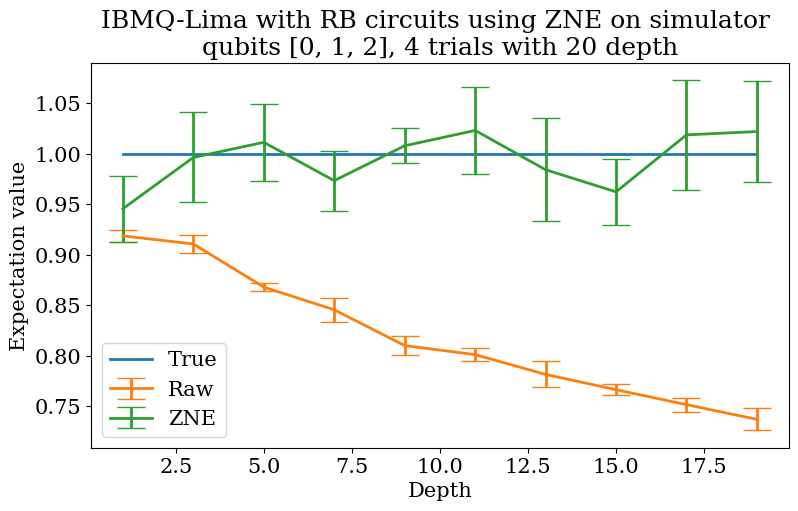

In [13]:
plt.figure(figsize=(9, 5))

kwargs = {"capsize": 10, "lw": 2}

plt.plot(depths, avg_true_values, label="True", lw=2)
plt.errorbar(depths, avg_noisy_values, yerr=std_noisy_values, label="Raw", **kwargs)

plt.errorbar(depths, avg_zne_values, yerr=std_zne_values, label="ZNE", **kwargs)

plt.title(f"""IBMQ-Lima with RB circuits using ZNE {"on simulator" if use_noisy_simulator else ""} \nqubits {qubits}, {trials} trials with {max_depth} depth""")
plt.xlabel("Depth")
plt.ylabel("Expectation value")
plt.legend();

## Supplemental material

## Additional theory on ZNE

#### Step 1: Intentionally scale noise

A technique to increase the noise level of a circuit at the gate level is to intentionally increase its depth. This can be obtained using either *unitary folding* or *identity scaling*.

In unitary folding, we perform a mapping $G \rightarrow G G^* G$. This mapping can be applied *globally* or *locally* as shown in the diagrams below.

*
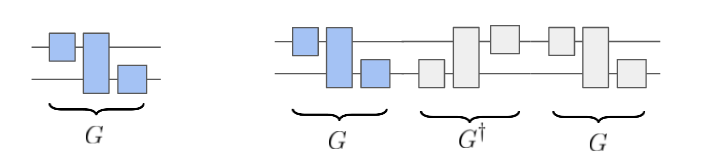

The diagram demonstrates how gates are inserted in a circuit when global folding is applied.

#### Step 2: Extrapolate to the noiseless limit

In both gate-model and pulse-model scenarios, let $\tau$ be a parameter quantifying noise level in the circuit and let $\tau^{\prime} = \lambda \tau$ the scaled noise level.

For $\lambda = 1$, the input circuit remains unchanged since the noise level $\tau^{\prime} = \tau$ is the same as the noise of the physical device without any scaling.

Let $\rho_{\tau^{\prime}}$ be the state prepared by a noise scaled quantum circuit. The expectation value of an observable $A$ can be described as a function of the noise scaling parameter as follows:

$$
\langle E(\lambda) \rangle = \text{Tr}(\rho_{\tau^{\prime}}A) = \text{Tr}(\rho_{\lambda \tau} A)
$$

The idea of ZNE is that one can estimate the ideal expectation value $\langle E(\lambda = 0) \rangle$, by measuring a range of different expectation values $\langle E(\lambda) \rangle$ for different values of $\lambda \geq 1$ and extrapolating to the zero-noise limit.

### Example: Computing a quantum expectation value without QEM

For example, we can define a circuit $U$ that prepares the GHZ state for $n$ qubits.

$$
U|00\ldots 0\rangle = \frac{|00\ldots 0 \rangle + |11\ldots 1\rangle}{\sqrt{2}}.
$$

We could define this circuit "from scratch", but for convenience, `mitiq` provides the circuit that defines this state

In [14]:
from mitiq.benchmarks import generate_ghz_circuit

# Ideal circuit that we want to prepare and measure in quantum computer.
n_qubits = 7
circuit = generate_ghz_circuit(n_qubits=n_qubits, return_type="qiskit")
print("GHZ circuit:")
print(circuit)

GHZ circuit:
     ┌───┐                              
q_0: ┤ H ├──■───────────────────────────
     └───┘┌─┴─┐                         
q_1: ─────┤ X ├──■──────────────────────
          └───┘┌─┴─┐                    
q_2: ──────────┤ X ├──■─────────────────
               └───┘┌─┴─┐               
q_3: ───────────────┤ X ├──■────────────
                    └───┘┌─┴─┐          
q_4: ────────────────────┤ X ├──■───────
                         └───┘┌─┴─┐     
q_5: ─────────────────────────┤ X ├──■──
                              └───┘┌─┴─┐
q_6: ──────────────────────────────┤ X ├
                                   └───┘


**Question**: What is the observable in this case that we want to measure? (QEM is well-defined when we desire to compute an expectation value of something).

Let us define the Hermitian observable:

$$
A = |00 \ldots 0 \rangle \langle 00 \ldots 0 | + |11 \ldots 1 \rangle \langle 11 \ldots 1|.
$$

In the **absense of noise**, the expectation value of $A$ is equal to $1$:

$$
\text{Tr}(\rho A) = \langle 00 \ldots 0| U^* A U |00 \ldots 0 \rangle = \frac{1}{2} + \frac{1}{2} = 1.
$$

This means that when measuring the state in the computational basis, we can only obtain either the bitstring $00\ldots0$ or the bitstring $11\ldots1$.

In the **presence of noise**, the expectation value of the same observable $A$ will be smaller. Let's verify this fact before applying error mitigation.

### GHZ circuit with noiseless and noisy backends

In this section, we will look at the impact of noise to motivate the ZNE error mitigation strategy. 

In [15]:
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit import transpile
from qiskit.providers import fake_provider

# "Shots" refer to the number of times that the circuit is repeated.
# To minimize sampling errors of any experiments, should maximize number of shots that circuit is run.
shots = 10 ** 5

### Noiseless GHZ circuit

We first execute the circuit on an ideal noiseless simulator.

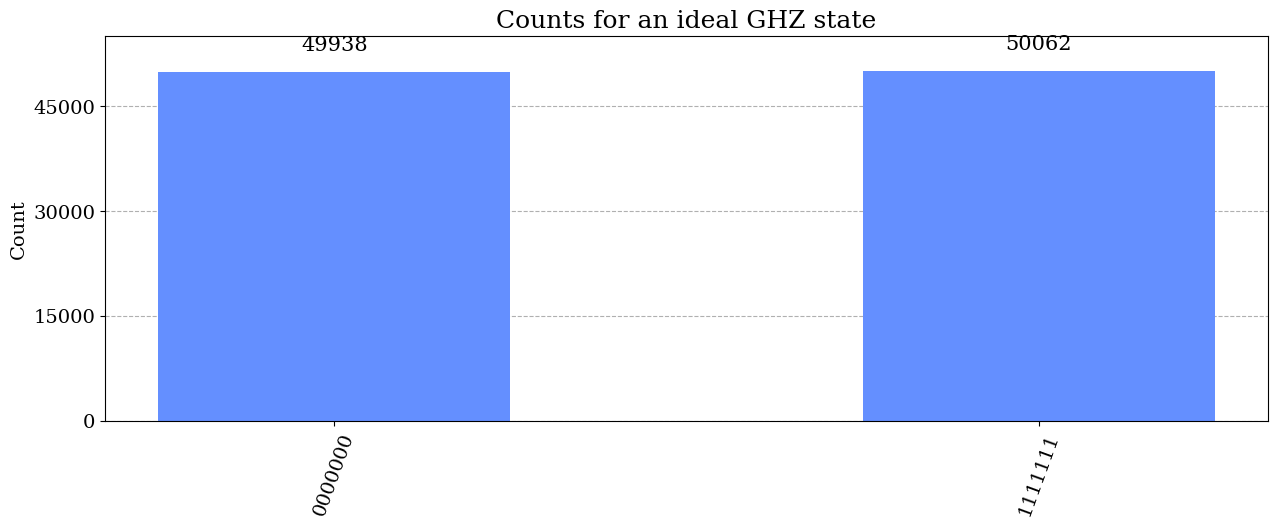

In [16]:
ideal_backend = AerSimulator()

# Append measurement gates
circuit_to_run = circuit.copy()
circuit_to_run.measure_all()

job = ideal_backend.run(circuit_to_run, shots=shots)

# The `get_counts()` method returns instances of various measured states, e.g.
# {'1111111': 512, '0000000': 512}
ideal_counts = job.result().get_counts()

plot_histogram(ideal_counts, title="Counts for an ideal GHZ state", figsize=(15, 5))

As exepcted, the ideal simulation of a measurement of a GHZ state yields either the $|00\ldots0\rangle$ or $|11\ldots1\rangle$ state with equal probabilitiy. 

**Note**: The histogram bars here are not perfectly split 50/50 as even if one had an ideal (noiseless) quantum computer, there will always be some statistical error. This is because we run some number of finite (probabilistic) measurements that naturally incur some type of statistical fluctuations. Taking an infinite number of measurements, the probabilities would be perfectly split 50/50.

*tl;dr*: The error here is due to the statistical fluctuations and not due to anything pertaining to the hardware. 

### Noisy GHZ circuit

We now execute the same circuit on a noisy backend (a classical emulator of the real $\texttt{ibmq-jakarta}$ QPU). This emulator is really just a noise model that should reproduce all of the errors that one would encounter on the actual (in this case $\texttt{ibmq-jakarta}$) device.

In [17]:
# QPU emulator:
noisy_backend = fake_provider.FakeJakarta()

# Compile the circuit into the native gates of the backend.
compiled_circuit = transpile(circuit_to_run, noisy_backend)

**Note**: The process of *transpilation* is similar to compilation. Given a circuit, it's possible that this circuit is defined using some gates that are not present in the hardware gateset. Transpilation decomposes the circuit's gates into ones that the hardware is able to run.

For instance, the transpiled GHZ circuit we previously defined uses the gates that are available on the $\texttt{ibmq-jakarta}$ backend that achieve the same result.

In [18]:
# Transpiled GHZ circuit.
print(compiled_circuit)

global phase: π/4
                                          ┌───┐     ┌───┐                    »
q_2 -> 0 ─────────────────────────────────┤ X ├──■──┤ X ├──■─────────────────»
                                     ┌───┐└─┬─┘┌─┴─┐└─┬─┘┌─┴─┐               »
q_1 -> 1 ────────────────────────────┤ X ├──■──┤ X ├──■──┤ X ├──■────────────»
         ┌─────────┐┌────┐┌─────────┐└─┬─┘     └───┘     └───┘  │            »
q_0 -> 2 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├──■────────────────────────┼────────────»
         └─────────┘└────┘└─────────┘                         ┌─┴─┐          »
q_3 -> 3 ─────────────────────────────────────────────────────┤ X ├──■───────»
                                                              └───┘  │  ┌───┐»
q_5 -> 4 ────────────────────────────────────────────────────────────┼──┤ X ├»
                                                                   ┌─┴─┐└─┬─┘»
q_4 -> 5 ──────────────────────────────────────────────────────────┤ X ├──■──»
                                  

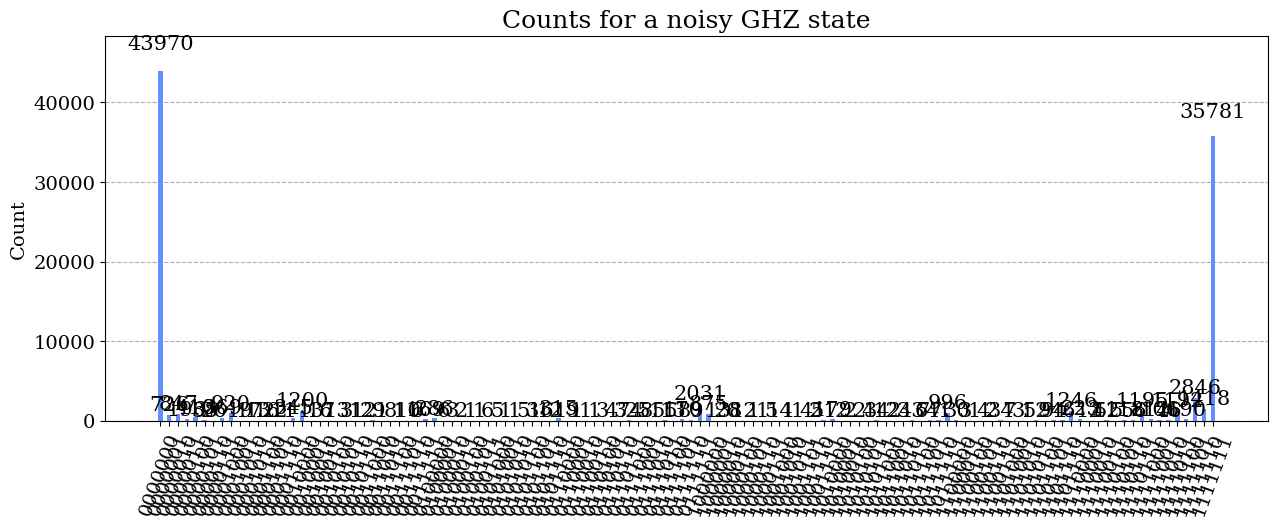

In [19]:
# Run the simulation on the noisy backend.
noisy_job = noisy_backend.run(compiled_circuit, shots=shots)
noisy_counts = noisy_job.result().get_counts()

plot_histogram(noisy_counts, title="Counts for a noisy GHZ state", figsize=(15, 5))

Once we have the `*_counts`, we need to compute the expectation value of the observable operator. The expectation of this operator is the probability of $|00\ldots0\rangle + |11\ldots1\rangle$

In [20]:
# <A> from ideal counts (normalized by number of shots):
ideal_expectation_value = (ideal_counts["0" * n_qubits] + ideal_counts["1" * n_qubits]) / shots
print(f"The ideal expectation value is <A> = {ideal_expectation_value}")

# <A> from noisy counts (normalized by number of shots):
noisy_expectation_value = (noisy_counts["0" * n_qubits] + noisy_counts["1" * n_qubits]) / shots
print(f"The ideal expectation value is <A> = {noisy_expectation_value}")

The ideal expectation value is <A> = 1.0
The ideal expectation value is <A> = 0.79751


Before using Mitiq, we ned to wrap the previous code into a function that takes as input a circuit and returns the noisy expectation value of the observable $A$. This function will be used by Mitiq as a black box during the error mitigation process.

In [21]:
def execute(compiled_circuit):
    """Executes the input circuits and returns the expectation value of A=|00...0><00...0| + |11...11><11..1|."""
    print(f"Executing a cicuit of depth: {compiled_circuit.depth()}")
    
    noisy_job = noisy_backend.run(compiled_circuit, shots=shots)
    noisy_counts = noisy_job.result().get_counts()
    noisy_expectation_value = (noisy_counts["0" * n_qubits] + noisy_counts["1" * n_qubits]) / shots
    
    return noisy_expectation_value

Let us check if the function works as expected.

In [22]:
print(f"The noisy expectation value is <A> = {execute(compiled_circuit)}")

Executing a cicuit of depth: 16
The noisy expectation value is <A> = 0.79429


We can now apply ZNE with Mitiq. Without advanced options, this requires a single line of code.

In [23]:
from mitiq import zne

zne_value = zne.execute_with_zne(circuit=compiled_circuit, executor=execute)
print(f"The error mitigated expectation value <A> = {zne_value}")

Executing a cicuit of depth: 16
Executing a cicuit of depth: 30
Executing a cicuit of depth: 46
The error mitigated expectation value <A> = 0.7823899999999988


**Note**: As you can see from the result output, Mitiq calls the `execute` function multiple times (3 in this case) to evaluate circuits of different depths in order to extrapolate the ideal result. 

Let us compare the absolute estimation error obtained with and without Mitiq.

In [24]:
print(f"Error without Mitiq: {abs(ideal_expectation_value - noisy_expectation_value)}")
print(f"Error with Mitiq: {abs(ideal_expectation_value - zne_value)}")

Error without Mitiq: 0.20248999999999995
Error with Mitiq: 0.2176100000000012
